### Notebook for the label transfer of Healthy Human Heart to mouse heart using `scANVI`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230918

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/ruth/mambaforge/envs/scvi-tools/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
absl                NA
aiohttp             3.8.5
aiosignal           1.3.1
annotated_types     0.5.0
anyio               NA
asttokens           NA
async_timeout       4.0.3
attr                23.1.0
backcall            0.2.0
backoff             2.2.1
bs4                 4.12.2
certifi             2023.07.22
charset_normalizer  3.2.0
chex                0.1.7
click               8.1.7
comm                0.1.4
contextlib2         NA
croniter            NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7.post1
decorator           5.1.1
deepdiff            6.3.1
docrep              0.3.2
etils               1.4.1
executing           1.2.0
fastapi             0.103.0
flax                0.7.2
frozenlist          1.4.0
fsspec              2023.6.0
h5py                3.9.0
idna                3.4
igraph              0.10.8
importlib_resources NA
ipykernel         

In [3]:
torch.set_float32_matmul_precision('high')

In [4]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Global seed set to 1712


In [5]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [6]:
reference = sc.read_h5ad('../data/hca_heart_global_ctl230918_states_formatted.h5ad')
reference

AnnData object with n_obs × n_vars = 452506 × 22260
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid'

In [7]:
reference.obs['cell_type'].value_counts()

cell_type
Ventricular_Cardiomyocyte    125289
Endothelial                  100579
Pericytes                     77856
Fibroblast                    58429
nan                           23837
Atrial_Cardiomyocyte          23483
Lymphoid                      16770
Smooth_muscle_cells           16242
Neuronal                       3961
Adipocytes                     3799
Myeloid                        1543
Mesothelial                     718
Name: count, dtype: int64

- Remove annotations with less than 10 cells

In [8]:
reference.obs['seed_labels'] = reference.obs['cell_type'].copy()
reference.obs['seed_labels'].value_counts()

seed_labels
Ventricular_Cardiomyocyte    125289
Endothelial                  100579
Pericytes                     77856
Fibroblast                    58429
nan                           23837
Atrial_Cardiomyocyte          23483
Lymphoid                      16770
Smooth_muscle_cells           16242
Neuronal                       3961
Adipocytes                     3799
Myeloid                        1543
Mesothelial                     718
Name: count, dtype: int64

In [9]:
reference.obs['seed_labels'].cat.categories

Index(['Adipocytes', 'Atrial_Cardiomyocyte', 'Endothelial', 'Fibroblast',
       'Lymphoid', 'Mesothelial', 'Myeloid', 'Neuronal', 'Pericytes',
       'Smooth_muscle_cells', 'Ventricular_Cardiomyocyte', 'nan'],
      dtype='object')

### Subset populations of interest

In [10]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]
reference.obs['seed_labels'].value_counts()

seed_labels
Ventricular_Cardiomyocyte    125289
Endothelial                  100579
Pericytes                     77856
Fibroblast                    58429
Atrial_Cardiomyocyte          23483
Lymphoid                      16770
Smooth_muscle_cells           16242
Neuronal                       3961
Adipocytes                     3799
Myeloid                        1543
Mesothelial                     718
Name: count, dtype: int64

In [11]:
sc.pp.filter_cells(reference, min_genes = 200)
sc.pp.filter_cells(reference, min_counts = 100)

In [12]:
reference.obs['cell_source'].value_counts()

cell_source
Harvard-Nuclei    159157
Sanger-Nuclei     158453
Sanger-CD45        66925
Sanger-Cells       44134
Name: count, dtype: int64

### Read in other query

In [13]:
query = sc.read_h5ad('../data/heart_mm_nuclei-23-0092_CB_QCed_ctl231108.raw.h5ad')
query.obs['cell_source'] = 'HIRI-Nuclei'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 112457 × 32285
    obs: 'sample', 'genotype', 'batch', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'cell_source', 'seed_labels', 'donor'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [14]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [15]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'GM16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

In [16]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')
adata

AnnData object with n_obs × n_vars = 541126 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-reference', 'n_cells-myeloid-refe

In [17]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].value_counts()

seed_labels
Ventricular_Cardiomyocyte    125289
Unknown                      112457
Endothelial                  100579
Pericytes                     77856
Fibroblast                    58429
Atrial_Cardiomyocyte          23483
Lymphoid                      16770
Smooth_muscle_cells           16242
Neuronal                       3961
Adipocytes                     3799
Myeloid                        1543
Mesothelial                     718
Name: count, dtype: int64

In [18]:
adata.obs['batch'].value_counts()

batch
reference    428669
query        112457
Name: count, dtype: int64

### Select HVGs

In [19]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 5000,
    layer = "counts",
    batch_key = "donor",
    subset = True
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 541126 × 5000
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-CD45-full-reference', 'n_cells-myeloid-refer

### Transfer of annotation with scANVI

In [20]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

In [21]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 50, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [22]:
scvi_model.train(75, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 use_gpu = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 75/75: 100%|██████████| 75/75 [27:44<00:00, 22.23s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.51e+3] 

`Trainer.fit` stopped: `max_epochs=75` reached.


Epoch 75/75: 100%|██████████| 75/75 [27:44<00:00, 22.20s/it, v_num=1, train_loss_step=1.7e+3, train_loss_epoch=1.51e+3]


### Evaluate model performance a la _Sevensson_

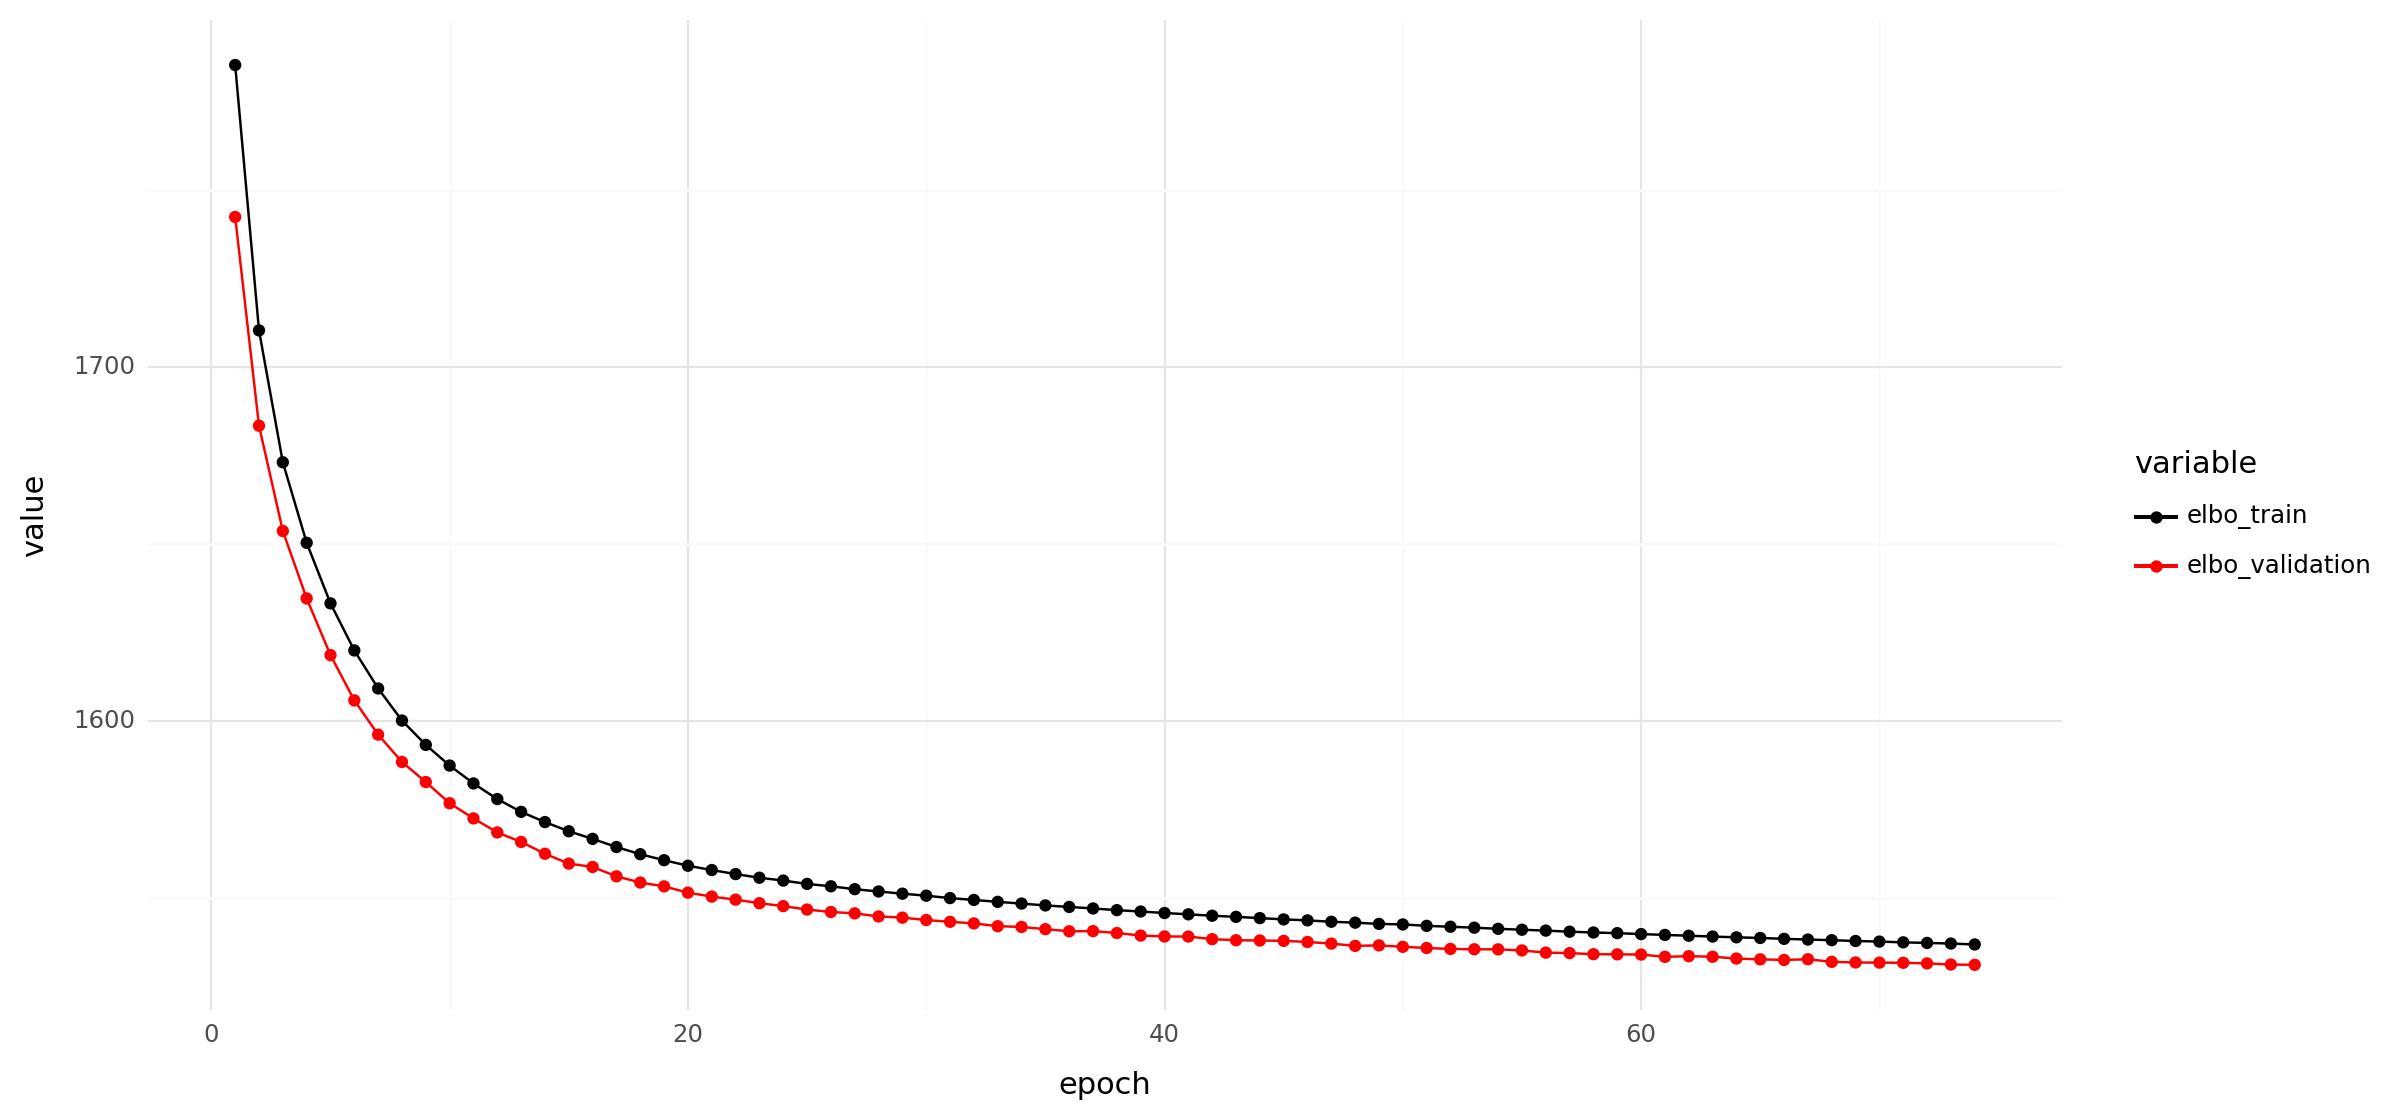

In [23]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

### Label transfer with `scANVI` 

In [24]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [25]:
scanvi_model.train(80, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True, 
                   use_gpu = 1)

INFO     Training for 80 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 80/80: 100%|██████████| 80/80 [1:24:26<00:00, 65.00s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.58e+3]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 80/80: 100%|██████████| 80/80 [1:24:26<00:00, 63.33s/it, v_num=1, train_loss_step=1.64e+3, train_loss_epoch=1.58e+3]


### Evaluate model performance a la Svensson

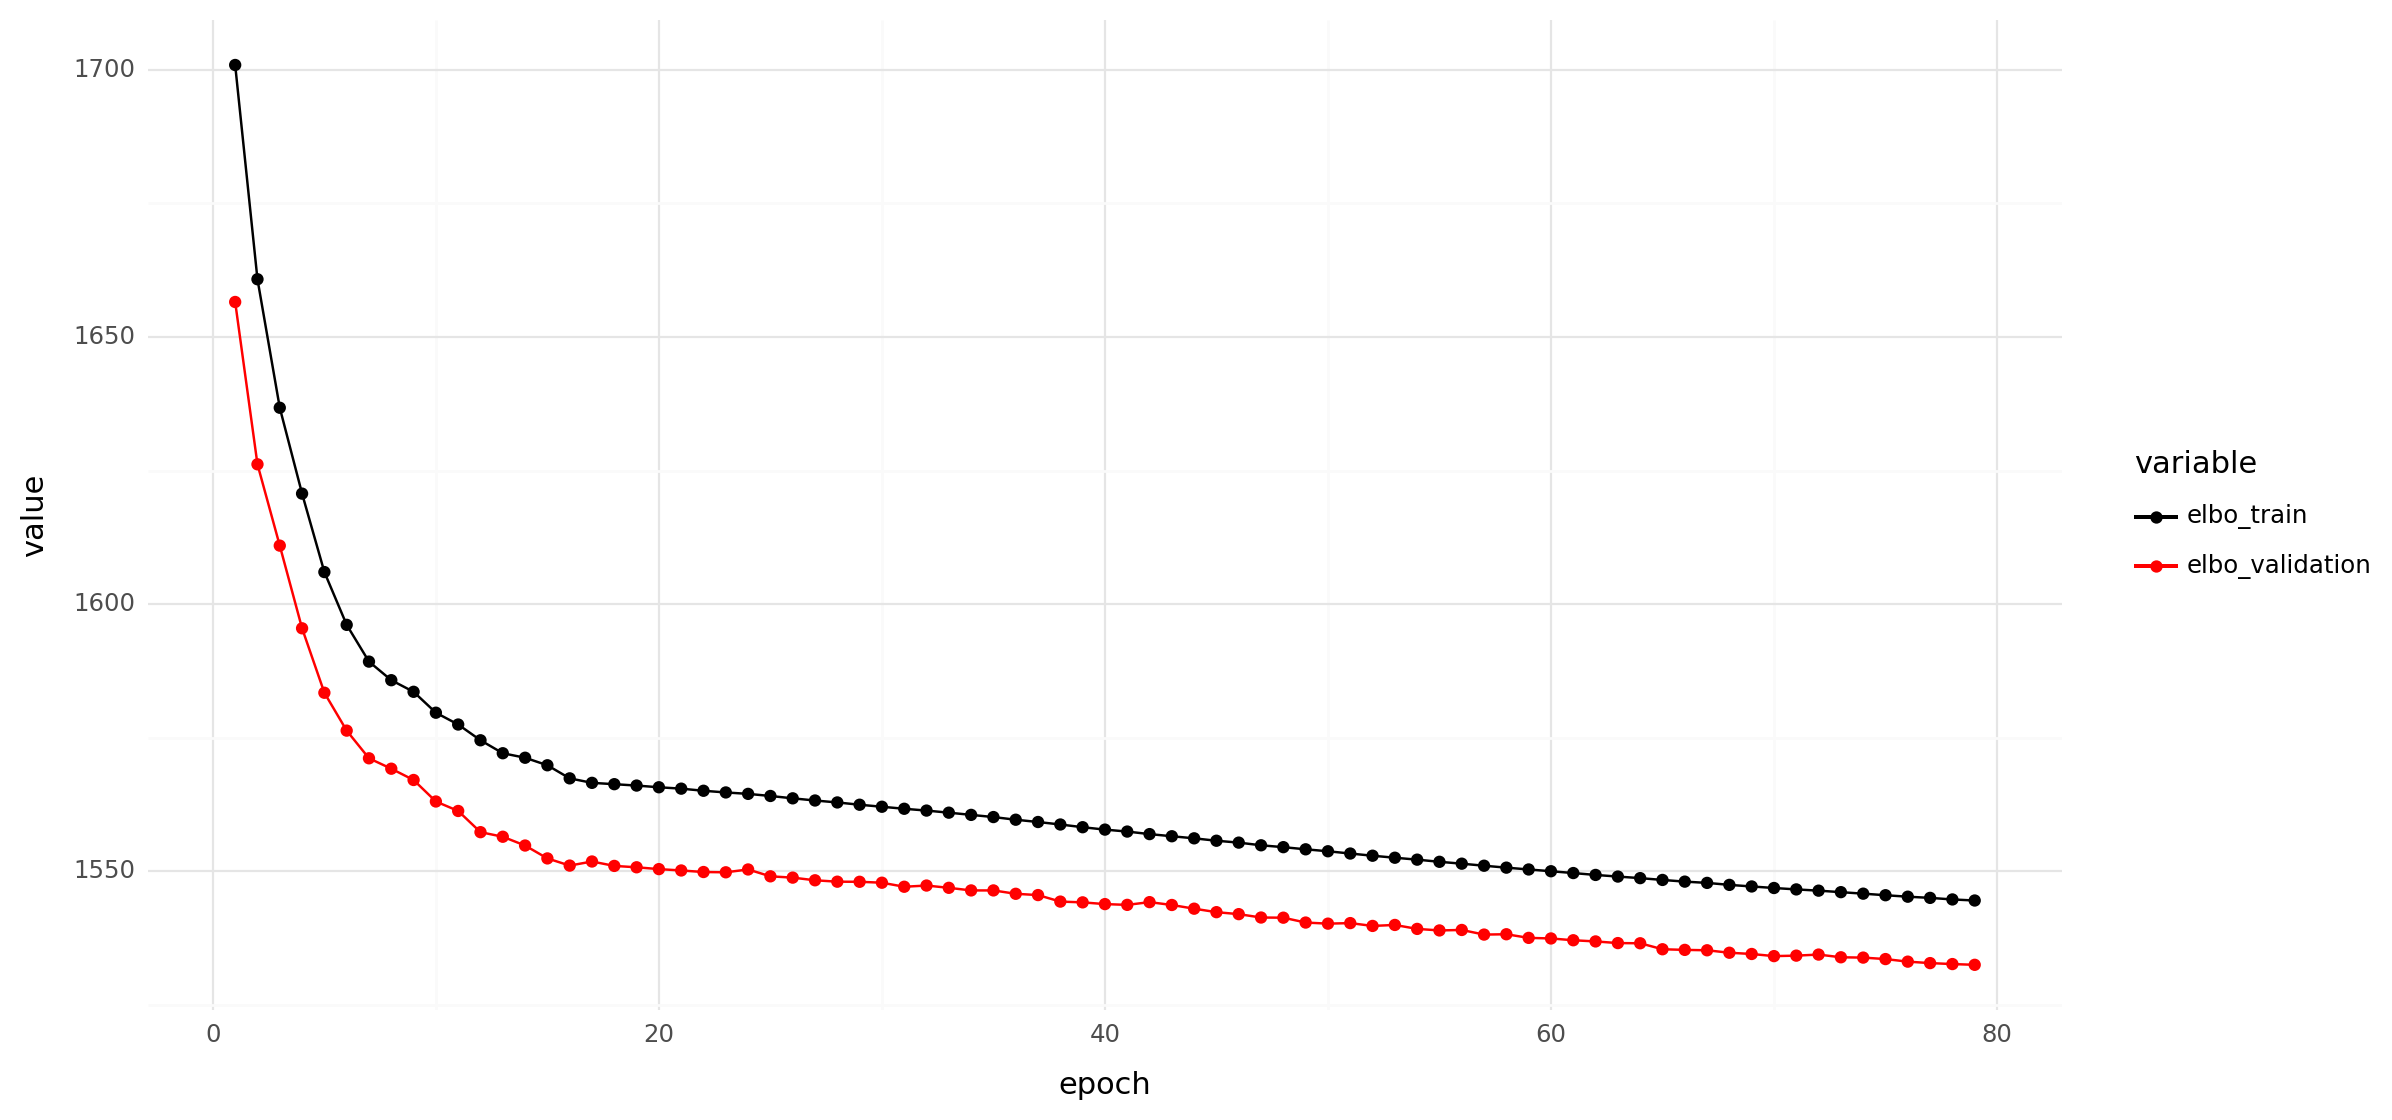

In [26]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

In [27]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [28]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

- Visualise corrected dataset

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:26)
the obs value 'sample' has more than 103 categories. Uniform 'grey' color will be used for all categories.


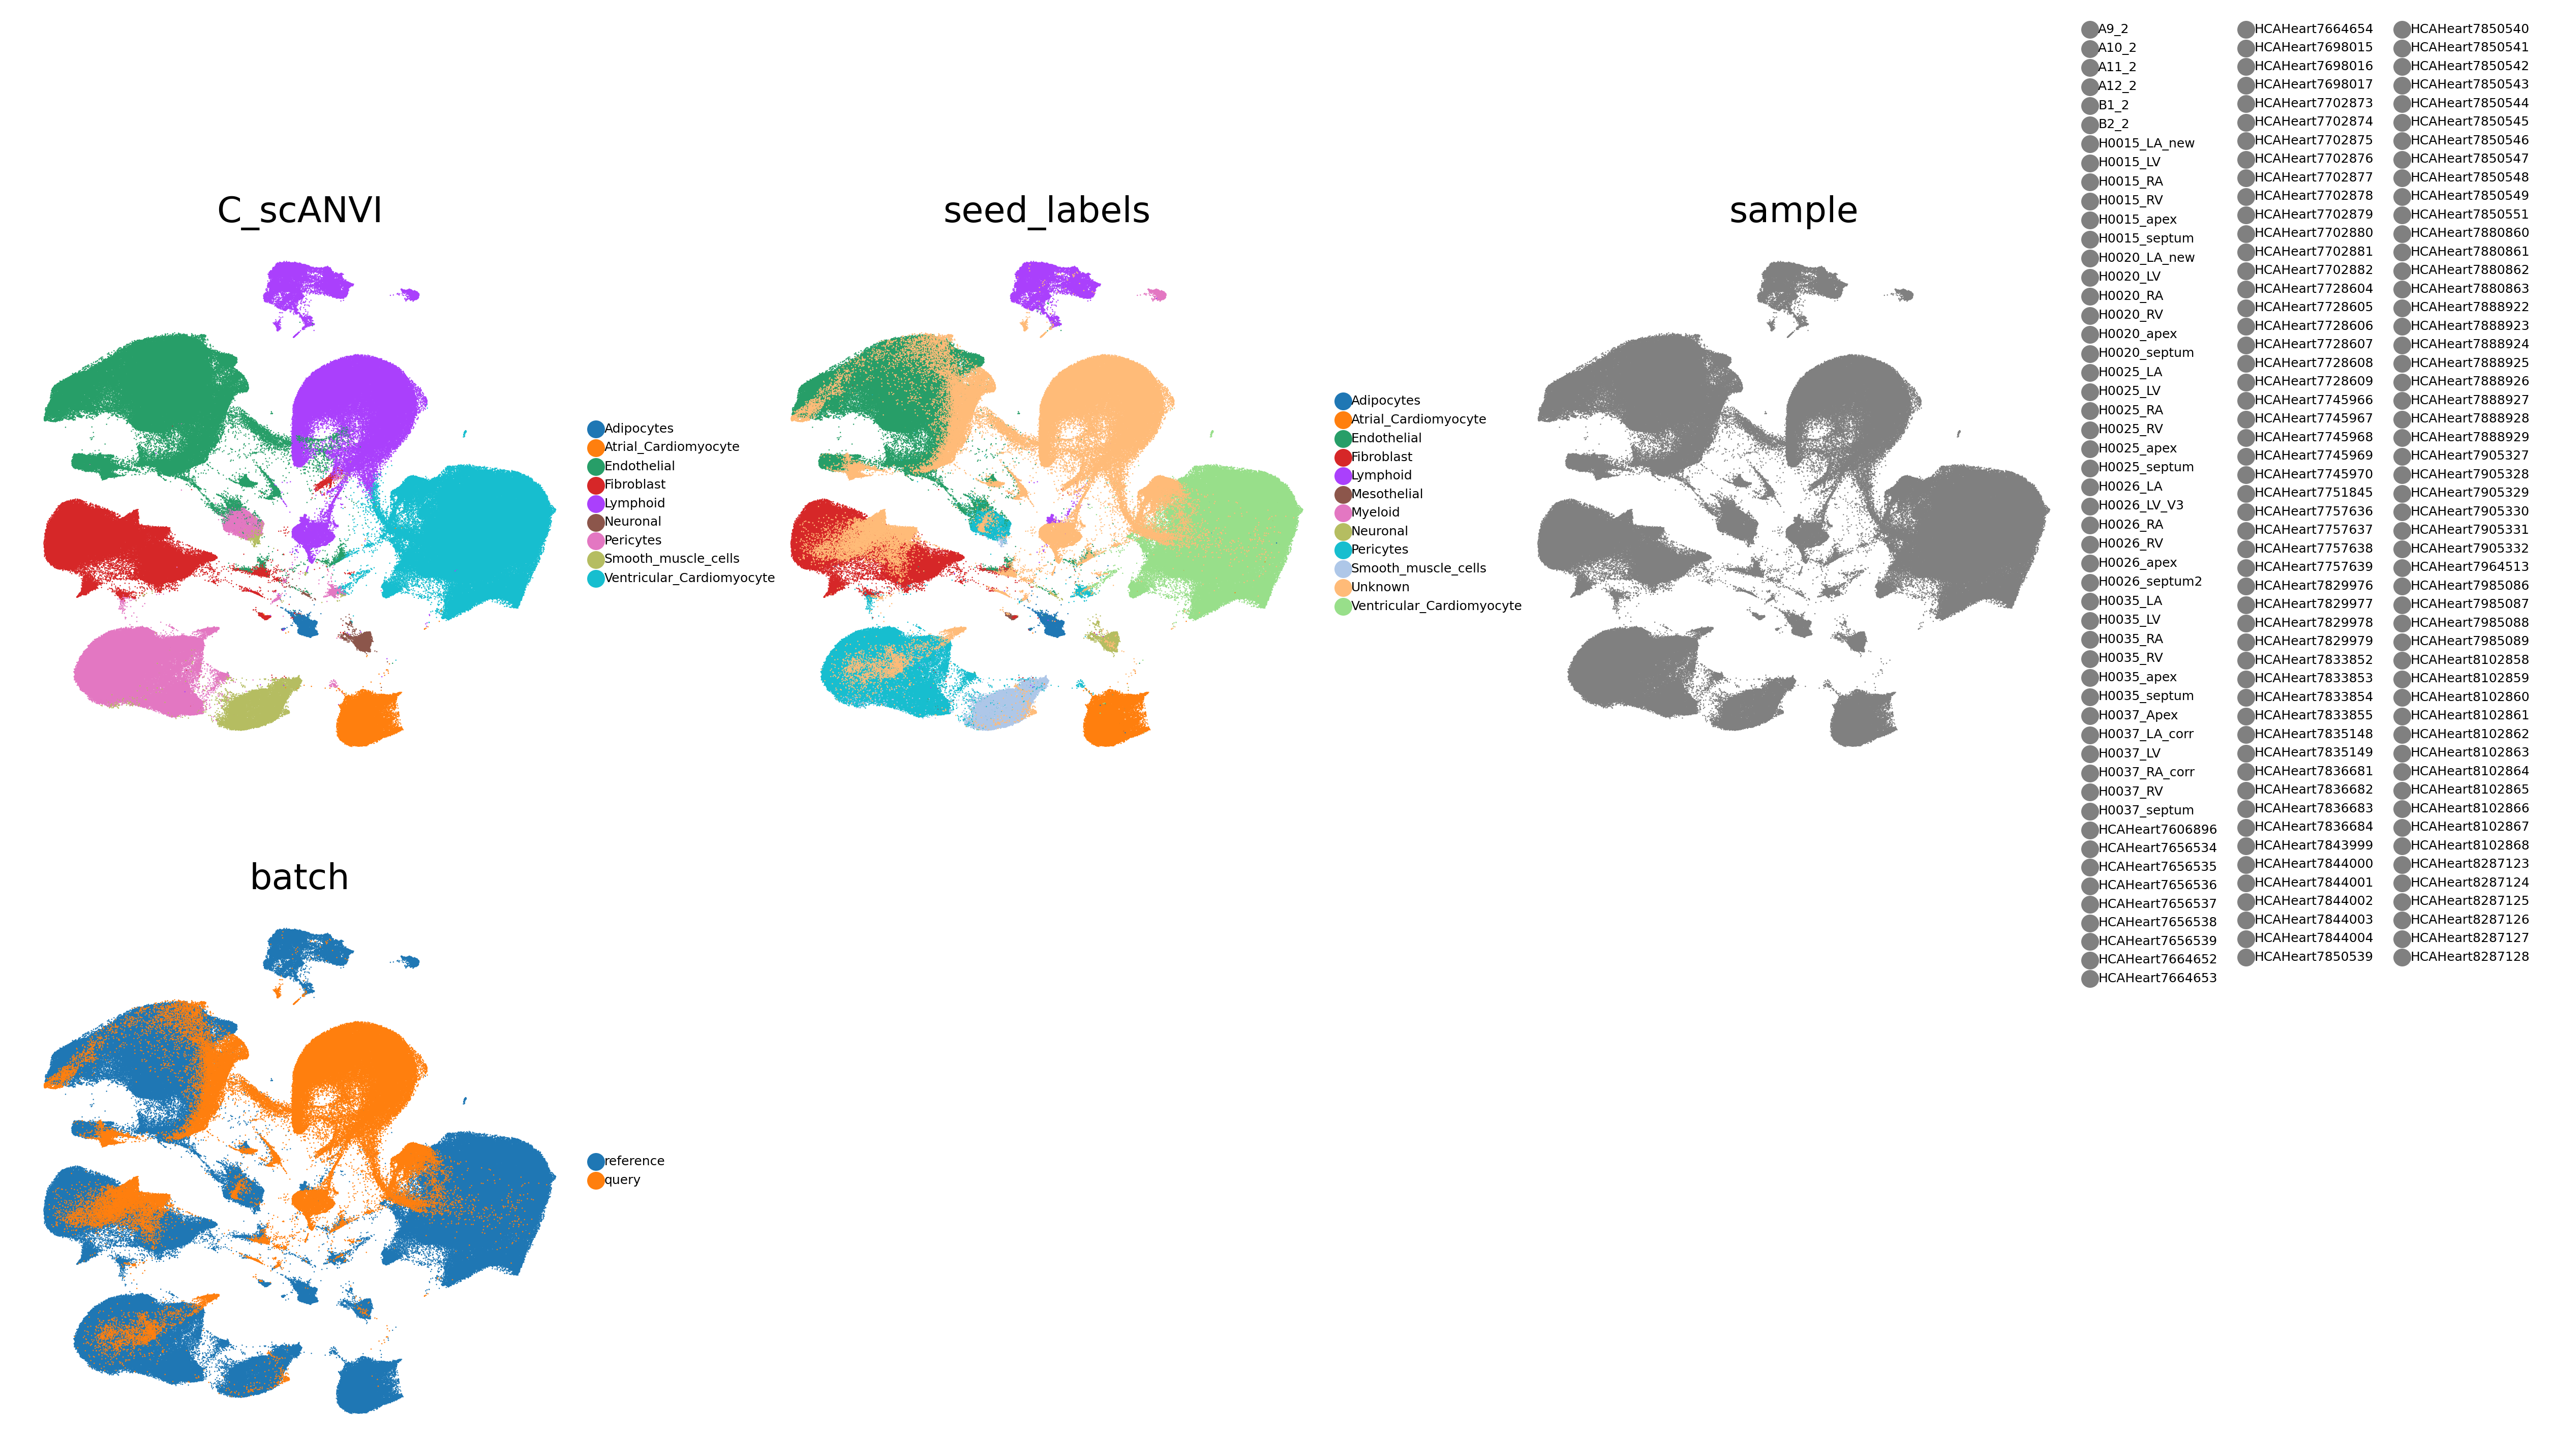

In [29]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'sample', 'batch'], size = 1, legend_fontsize = 5, ncols = 3)

### Export annotated object

In [30]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)
adata_export_merged

AnnData object with n_obs × n_vars = 541126 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types-Sanger-

In [31]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]
adata_export

View of AnnData object with n_obs × n_vars = 112457 × 14249
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids-query', 'feature_types-query', 'genome-query', 'mt-query', 'ribo-query', 'n_cells_by_counts-query', 'mean_counts-query', 'pct_dropout_by_counts-query', 'total_counts-query', 'gene_ids-Harvard-Nuclei-full-reference', 'feature_types-Harvard-Nuclei-full-reference', 'gene_ids-Sanger-Nuclei-full-reference', 'feature_types-Sanger-Nuclei-full-reference', 'gene_ids-Sanger-Cells-full-reference', 'feature_types-Sanger-Cells-full-reference', 'gene_ids-Sanger-CD45-full-reference', 'feature_types

### Add new gene symbols

In [32]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)
query_export

AnnData object with n_obs × n_vars = 112457 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Revert gene symbols

In [33]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]
query_export.var_names

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'Ac163611.1', 'Ac163611.2', 'Ac140365.1', 'Ac124606.2',
       'Ac124606.1', 'Ac133095.2', 'Ac133095.1', 'Ac234645.1', 'Ac149090.1'],
      dtype='object', length=32285)

In [34]:
query_export.obs['C_scANVI'].value_counts()

C_scANVI
Lymphoid                     68181
Endothelial                  21599
Fibroblast                   10252
Ventricular_Cardiomyocyte     8316
Pericytes                     3588
Smooth_muscle_cells            402
Neuronal                        75
Atrial_Cardiomyocyte            37
Adipocytes                       7
Name: count, dtype: int64

In [35]:
query_export

AnnData object with n_obs × n_vars = 112457 × 32285
    obs: 'cell_source', 'cell_type', 'donor', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'cell_states', 'seed_labels', 'genotype', 'batch', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [36]:
query_export.write('../data/heart_mm_nuclei-23-0092_scANVI-CellStates_ctl231119.raw.h5ad')